In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import math
import numpy as np
import hdbscan
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

In [2]:
import mdtraj as md
from mastermsm.trajectory import traj

In [3]:
trajs = traj.MultiTimeSeries(top='data/ala5_ff99sbildn_nowat.gro',\
        trajs=['data/ala5_ff99sbildn_tip3p_nvt_proc.xtc'])    

In [4]:
def dPCA(angles, t):
    """
    Compute PCA of dihedral angles

    We follow the methods described in A. Altis et al. 
    *J. Chem. Phys.*  244111 (2007)

    Parameters
    ----------
    angles :
    
    t : 
    
    Returns
    -------
    
    """
    shape = np.shape(angles)
    print (shape)
    X = np.zeros((shape[0] , \
                  shape[1]+shape[1]))
    for i, ang in enumerate(angles):
        p = 0
        for phi in ang:
            X[i][p], X[i][p+1] = np.cos(phi), np.sin(phi)
            p += 2
    X_std = StandardScaler().fit_transform(X)
    sklearn_pca = PCA(n_components=2*shape[1])
    
    X_transf = sklearn_pca.fit_transform(X_std)
    expl = sklearn_pca.explained_variance_ratio_
    
    print("Ratio of variance retrieved by each component:", expl)
    #graficamos el acumulado de varianza explicada en las nuevas dimensiones
    #plt.figure()
    #plt.plot(np.cumsum(sklearn_pca.explained_variance_ratio_))
    #plt.xlabel('number of components')
    #plt.ylabel('cumulative explained variance')
    #plt.savefig('cum_variance_%g.png'%t)

    #colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', \
    #'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'lightgray']
    #vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
    #counts, ybins, xbins, image = plt.hist2d(X_transf[:,0], X_transf[:,1], \
                #bins=[np.linspace(-np.pi,np.pi,20), np.linspace(-np.pi,np.pi,30)], \
    #            bins=20, cmap='binary_r', alpha=0.2)
    #plt.contour(np.transpose(counts), extent=[xbins.min(), xbins.max(), \
    #            ybins.min(), ybins.max()], linewidths=1, colors='gray')
    #countmax = np.amax(counts)
    #counts = np.log(countmax) - np.log(counts)
    #plt.scatter(X_transf[:,0],X_transf[:,1], c=counts)
    #plt.savefig('dpca_%g.png'%t)

    return X_transf

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mastermsm.trajectory import traj_lib

phi_cum = []
psi_cum = []
for t, tr in enumerate(trajs.traj_list):
    phi = md.compute_phi(tr.mdt)
    psi = md.compute_psi(tr.mdt)
    phi_cum.append(phi[1])
    psi_cum.append(psi[1])
    #reshape(-1,1))#phi_cum.append(phi[1])#[[v[i,0]] for i in range(len(v[:,0]))]
    #psi_cum.append(v[:,1].reshape(-1,1))#psi_cum.append(psi[1])
    #print(len(phi_cum),type(phi_cum))
phi_cum = np.vstack(phi_cum)
psi_cum = np.vstack(psi_cum)
phi_fake = [phi[0], phi_cum]
psi_fake = [psi[0], psi_cum]
angles = np.column_stack((phi_cum, psi_cum))

v = dPCA(angles, t)
v.shape
print(phi_cum.shape,psi_cum.shape)

(250001, 10)
Ratio of variance retrieved by each component: [0.109936   0.09352144 0.08805895 0.07246941 0.0687701  0.06354626
 0.0610928  0.05553368 0.05163301 0.04758494 0.04519939 0.0427791
 0.03885436 0.03463574 0.03200618 0.02318423 0.01945065 0.01859857
 0.01710293 0.01604226]
(250001, 5) (250001, 5)


In [6]:
ndih = len(phi_fake[0])
phis, psis = [], []
for f, y in zip(phi_fake[1],psi_fake[1]):
    for n in range(ndih):
        phis.append(f[n])
        psis.append(y[n])
    
data = np.column_stack((range(len(phis)),phis,psis))
print(data.shape)

(1250005, 3)


In [19]:
X = StandardScaler().fit_transform(v)
hb = hdbscan.HDBSCAN(min_cluster_size = 70, min_samples=70).fit(X)
n_micro_clusters = len(set(hb.labels_)) - (1 if -1 in hb.labels_ else 0)
print("n_micro_clusters:",n_micro_clusters)
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', \
'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'lightgray']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
#plt.scatter(X[:,0],X[:,1], c=vectorizer(hb.labels_), s=2)
#plt.show

n_micro_clusters: 4


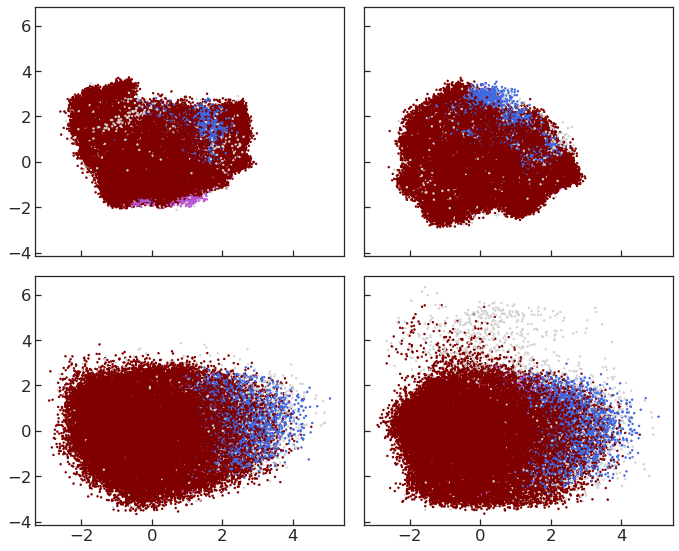

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(10,8), sharex=True, sharey=True)
ax[0,0].scatter(X[:,0], X[:,1], c=vectorizer(hb.labels_), s=2)
ax[0,1].scatter(X[:,0], X[:,2], c=vectorizer(hb.labels_), s=2)
ax[1,0].scatter(X[:,5], X[:,9], c=vectorizer(hb.labels_), s=2)
ax[1,1].scatter(X[:,5], X[:,19], c=vectorizer(hb.labels_), s=2)
plt.tight_layout()

In [21]:
#hb.condensed_tree_.plot()

### NOW USE THIS LABELING TO IDENTIFY CLUSTERS ON RAMACHANDRAN PLOT OF EACH PEPTIDE:

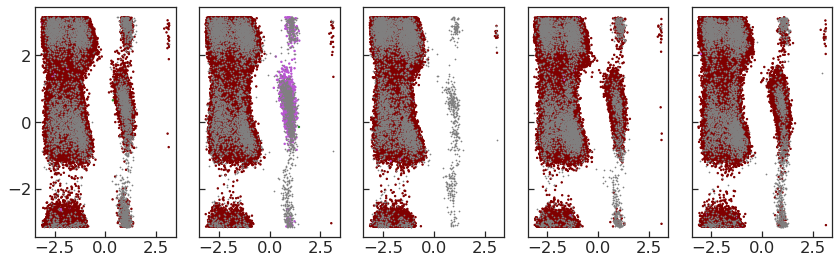

In [23]:
fig,ax = plt.subplots(1,5,figsize=(12,4), sharex=True, sharey=True)
assign = hb.labels_>=0.01
noise = hb.labels_<0.0
for i in range(5):
    ax[i].scatter(phi_cum[assign,i-1],psi_cum[assign,i-1], s=2, c=vectorizer(hb.labels_[assign]))
    ax[i].scatter(phi_cum[noise,i-1],psi_cum[noise,i-1], c='gray', s=0.5)
plt.tight_layout()